In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.nn import Sequential, Linear
from torch.optim import SGD

In [2]:
df = pd.read_csv('datasets/electric_veh_reduced.csv')
df.head()

,Model Year,Make,Model,Electric Range,Base MSRP,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Legislative District,Electric Utility
0,2013,TESLA,MODEL S,208.0,69900.0,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,21.0,PUGET SOUND ENERGY INC
1,2018,VOLVO,XC60,17.0,52900.0,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,10.0,PUGET SOUND ENERGY INC
2,2013,TESLA,MODEL S,208.0,69900.0,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,40.0,PUGET SOUND ENERGY INC
3,2014,TESLA,MODEL S,208.0,69900.0,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,17.0,BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF C...
4,2018,BMW,330E,14.0,45600.0,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,45.0,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA)


In [3]:
X = df[['Model Year', 'Electric Range', 'Make']]
y = df['Base MSRP']

X_encoded = pd.get_dummies(X, columns=['Make'])
# X_encoded = X_encoded.drop('Make', axis=1)
print(X_encoded.shape)
X_encoded.head(10)

(3407, 13)


,Model Year,Electric Range,Make_BMW,Make_CADILLAC,Make_CHRYSLER,Make_FISKER,Make_KIA,Make_MINI,Make_PORSCHE,Make_SUBARU,Make_TESLA,Make_VOLVO,Make_WHEEGO ELECTRIC CARS
0,2013,208.0,0,0,0,0,0,0,0,0,1,0,0
1,2018,17.0,0,0,0,0,0,0,0,0,0,1,0
2,2013,208.0,0,0,0,0,0,0,0,0,1,0,0
3,2014,208.0,0,0,0,0,0,0,0,0,1,0,0
4,2018,14.0,1,0,0,0,0,0,0,0,0,0,0
5,2019,17.0,0,0,0,0,0,0,0,0,0,1,0
6,2013,208.0,0,0,0,0,0,0,0,0,1,0,0
7,2013,208.0,0,0,0,0,0,0,0,0,1,0,0
8,2014,208.0,0,0,0,0,0,0,0,0,1,0,0
9,2014,208.0,0,0,0,0,0,0,0,0,1,0,0


# Regression Model with PyTorch

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# setting device to gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


X_train, X_temp, y_train, y_temp = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# splitting the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(X_train.shape, y_train.shape)
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_val_np = X_val.to_numpy()
y_val_np = y_val.to_numpy()
# Convert NumPy arrays to PyTorch tensors
features_tensor = torch.FloatTensor(X_train_np)
labels_tensor = torch.FloatTensor(y_train_np)
X_val_tensor = torch.FloatTensor(X_val_np)
y_val_tensor = torch.FloatTensor(y_val_np)

# Create a DataLoader
dataset = TensorDataset(features_tensor, labels_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
# X_train.head()

cuda
(2725, 13) (2725,)


In [6]:
class ElectricVehicleModel(nn.Module):
    def __init__(self, input_size):
        super(ElectricVehicleModel, self).__init__()
        self.l1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.l2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        x = self.relu1(self.l1(x))
        x = self.relu2(self.l2(x))
        x = self.output_layer(x)
        return x

# instantiate the model
model = ElectricVehicleModel(X_train.shape[1])
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
model.to(device)
features_tensor = features_tensor.to(device)
labels_tensor = labels_tensor.to(device)

# Print the model architecture
print(model)

# Lists to store parameters and loss history
parameters_history = []
loss_history = []
loss_history_val = []
loss_history_mae = []
best_loss = float('inf')
best_parameters = None

for param in model.parameters():
    param.to(device)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    for batch_features, batch_labels in dataloader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels.view(-1, 1))
        loss.backward()
        optimizer.step()
    # Store parameters and loss at the end of each epoch
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_parameters = [param.data.clone() for param in model.parameters()]
    # parameters_history.append([param.data.clone() for param in model.parameters()])
    loss_history.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor.to(device))
        val_loss = criterion(val_outputs.squeeze(), y_val_tensor.to(device))
        mae_loss = nn.L1Loss()(val_outputs.squeeze(), y_val_tensor.to(device))
        loss_history_mae.append(mae_loss.item())
        loss_history_val.append(val_loss.item())

    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.2f}, Val Loss: {val_loss.item():.2f}, MAE: {mae_loss.item():.2f}')

ElectricVehicleModel(
  (l1): Linear(in_features=13, out_features=128, bias=True)
  (relu1): ReLU()
  (l2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)
Epoch 100/1000, Loss: 149276400.00, Val Loss: 152701472.00, MAE: 8736.19
Epoch 200/1000, Loss: 204777776.00, Val Loss: 133462720.00, MAE: 8559.39
Epoch 300/1000, Loss: 16668193.00, Val Loss: 53498584.00, MAE: 3038.41
Epoch 400/1000, Loss: 31399462.00, Val Loss: 52216312.00, MAE: 4252.31
Epoch 500/1000, Loss: 34961808.00, Val Loss: 41452060.00, MAE: 2595.39
Epoch 600/1000, Loss: 53622752.00, Val Loss: 37667188.00, MAE: 2812.85
Epoch 700/1000, Loss: 28781818.00, Val Loss: 35620120.00, MAE: 2798.92
Epoch 800/1000, Loss: 65147788.00, Val Loss: 36830744.00, MAE: 3154.80
Epoch 900/1000, Loss: 5894659.50, Val Loss: 32440726.00, MAE: 2161.74
Epoch 1000/1000, Loss: 51803524.00, Val Loss: 32235808.00, MAE: 2078.54


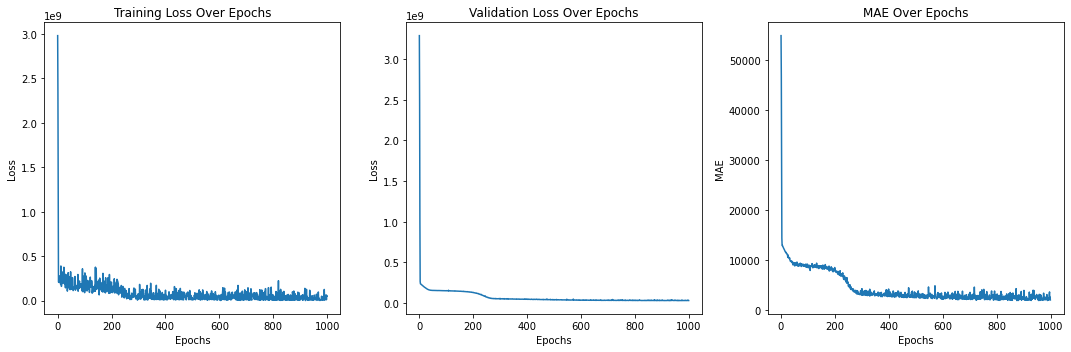

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.lineplot(x=range(num_epochs), y=loss_history, ax=ax[0])
ax[0].set_title('Training Loss Over Epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
sns.lineplot(x=range(num_epochs), y=loss_history_val, ax=ax[1])
ax[1].set_title('Validation Loss Over Epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
sns.lineplot(x=range(num_epochs), y=loss_history_mae, ax=ax[2])
ax[2].set_title('MAE Over Epochs')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('MAE')
fig.tight_layout()
plt.show()

In [10]:
from torchsummary import summary

# model summary
summary(model, input_size=(1, 13))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]           1,792
              ReLU-2               [-1, 1, 128]               0
            Linear-3                [-1, 1, 64]           8,256
              ReLU-4                [-1, 1, 64]               0
            Linear-5                 [-1, 1, 1]              65
Total params: 10,113
Trainable params: 10,113
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [11]:
# Model parameters
for name, param in model.named_parameters():
    print(f'Parameter name: {name}, Shape: {param.shape}')
    print(param)
    print()

Parameter name: l1.weight, Shape: torch.Size([128, 13])
Parameter containing:
tensor([[ 1.1443e-01, -6.1207e-01,  2.0325e+00,  ...,  1.0464e+01,
          3.6743e+00, -8.8783e+00],
        [-1.4033e-01, -1.0127e-01, -2.1863e-01,  ..., -2.3039e-01,
         -1.9214e-01,  1.9127e-01],
        [-1.9252e-01, -2.1449e-01, -8.0506e-02,  ..., -2.3133e-01,
          6.5000e-02, -9.6814e-02],
        ...,
        [-5.2231e-02, -7.1039e-02, -1.7502e-01,  ...,  3.9562e-02,
         -2.7126e-01, -1.2229e-01],
        [ 7.8941e-03, -9.1646e-02,  2.2478e+00,  ...,  1.0912e+01,
          3.5325e+00, -7.1868e+00],
        [-7.4708e-02, -2.6531e-01, -2.3363e-02,  ...,  1.3577e-01,
          1.9460e-01,  1.4586e-01]], device='cuda:0', requires_grad=True)

Parameter name: l1.bias, Shape: torch.Size([128])
Parameter containing:
tensor([-2.2411e-01,  5.6264e-02,  1.2858e-01, -1.9725e-01, -1.3329e-02,
        -1.3858e-01,  7.6099e-02, -2.1974e-01,  2.2783e-01, -1.4336e-01,
         1.9709e-01, -2.1913e-01, 

In [12]:
model.load_state_dict({param_name: param for param_name, param in zip(model.state_dict().keys(), best_parameters)})

model.eval()

new_input = torch.FloatTensor(X_test.to_numpy()).to(device)
y_test_tensor = torch.FloatTensor(y_test.to_numpy()).to(device)

# Forward pass to get the prediction
with torch.no_grad():
    y_pred = model(new_input)

# Mean Squared Error and Mean Absolute Error
mse = nn.MSELoss()(y_pred.squeeze(), y_test_tensor)
print(f'Mean Squared Error on Test Data: {mse.item()}')
mae = nn.L1Loss()(y_pred.squeeze(), y_test_tensor)
# mae = nn.L1Loss(y_pred, y_test_tensor.unsqueeze(dim=1))
print(f'Mean Absolute Error: {mae:.2f}')

Mean Squared Error on Test Data: 51298280.0
Mean Absolute Error: 2799.16


In [32]:
X_test.head()

,Model Year,Electric Range,Make_BMW,Make_CADILLAC,Make_CHRYSLER,Make_FISKER,Make_KIA,Make_MINI,Make_PORSCHE,Make_SUBARU,Make_TESLA,Make_VOLVO,Make_WHEEGO ELECTRIC CARS
3305,2016,93.0,0,0,0,0,1,0,0,0,0,0,0
1204,2017,14.0,1,0,0,0,0,0,0,0,0,0,0
903,2017,93.0,0,0,0,0,1,0,0,0,0,0,0
2785,2013,208.0,0,0,0,0,0,0,0,0,1,0,0
1080,2018,19.0,0,0,0,0,0,0,0,0,0,1,0


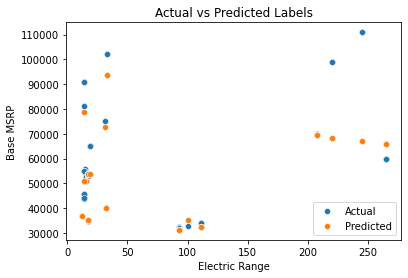

In [31]:
# visualization
sns.scatterplot(x=X_test['Electric Range'].to_numpy(), y=y_test.to_numpy(), label='Actual')
sns.scatterplot(x=X_test['Electric Range'].to_numpy(), y=y_pred.squeeze().cpu().numpy(), label='Predicted')
plt.xlabel('Electric Range')
plt.ylabel('Base MSRP')
plt.title('Actual vs Predicted Labels')
plt.legend()
plt.show()